<a href="https://colab.research.google.com/github/juan-scholarium/certificate/blob/main/training-model/thesis-keras_enhance_green.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetic Retinopathy Classification

In this notebook I trained Inception v3 model using dataset that rescaled only, without any image processing.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!nvidia-smi

Wed Oct 21 14:54:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# import library
import os
import datetime
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics, losses, optimizers, models, callbacks, utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import inception_v3

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from matplotlib import pyplot as plt
plt.style.use("dark_background")

In [5]:
# define plot function
def plot_loss(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, label="training loss")
    plt.plot(epochs, val_loss, label="valid loss")
    plt.title("Training & Valid Loss")
    plt.legend()
    plt.show()

def plot_acc(history):
    acc = history.history["categorical_accuracy"]
    val_acc = history.history["val_categorical_accuracy"]
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label="training acc")
    plt.plot(epochs, val_acc, label="valid acc")
    plt.title("Training & Valid Accuracy")
    plt.legend()
    plt.show()

def plot_precision(history):
    precision = history.history["precision"]
    val_precision = history.history["val_precision"]
    epochs = range(1, len(precision) + 1)

    plt.plot(epochs, precision, label="training precision")
    plt.plot(epochs, val_precision, label="valid precision")
    plt.title("Training & Valid Precision")
    plt.legend()
    plt.show()


def plot_recall(history):
    recall = history.history["recall"]
    val_recall = history.history["val_recall"]
    epochs = range(1, len(recall) + 1)

    plt.plot(epochs, recall, label="training recall")
    plt.plot(epochs, val_recall, label="valid recall")
    plt.title("Training & Valid Recall")
    plt.legend()
    plt.show()


def plot_auc(history):
    auc = history.history["auc"]
    val_auc = history.history["val_auc"]
    epochs = range(1, len(auc) + 1)

    plt.plot(epochs, auc, label="training auc")
    plt.plot(epochs, val_auc, label="valid auc")
    plt.title("Training & Valid AUC")
    plt.legend()
    plt.show()

# Prepare dataset & base model

- Split train & test
- Compute weight for each class
- Create Image generator
- Create model

In [6]:
# define our working directory
base_dir = "/content/drive/My Drive/dataset/aptos2019-enhance-green"
image_dir = os.path.join(base_dir, "train_images")
save_dir = os.path.join(base_dir, "models")

In [7]:
# load csv file that contains our image file name & its label
df = pd.read_csv(os.path.join(base_dir, "train.csv"))
df.head(3)

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1

In [8]:
df["id_code"] = df["id_code"] + ".png"
df = df.astype(str)
df.head()

id_code diagnosis
0  000c1434d8d7.png         2
1  001639a390f0.png         4
2  0024cdab0c1e.png         1
3  002c21358ce6.png         0
4  005b95c28852.png         0

In [9]:
# split dataset into train & validation with proportional quantity
train_df, valid_df = train_test_split(
    df, test_size=0.2, stratify=df["diagnosis"])

In [10]:
class_label = np.array(np.unique(df["diagnosis"]))
class_label

array(['0', '1', '2', '3', '4'], dtype=object)

In [11]:
diagnosis = np.array(df["diagnosis"])
diagnosis.shape

(3662,)

In [12]:
# create class weight because our dataset is imbalance
class_weight = compute_class_weight("balanced", class_label, diagnosis)

dict_class_weight = dict()
for i in range(5):
    dict_class_weight[i] = class_weight[i]
dict_class_weight

{0: 0.4057617728531856,
 1: 1.9794594594594594,
 2: 0.7331331331331331,
 3: 3.7948186528497407,
 4: 2.4827118644067796}

In [13]:
image_shape = (384, 384, 3)
batch_size = 16

In [14]:
# we minimize the augmentation, in case preprocessing is destroyed?
train_datagen = image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    fill_mode="reflect",
    # zoom_range=[0.9, 1.1],
    # brightness_range=[0.9, 1.1],
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.2,
    data_format="channels_last",
)

test_datagen = image.ImageDataGenerator(
    data_format="channels_last", )

In [15]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=image_dir,
    x_col="id_code",
    y_col="diagnosis",
    target_size=image_shape[:2],
    class_mode="categorical",
    batch_size=batch_size,
)

valid_generator = test_datagen.flow_from_dataframe(
    valid_df,
    directory=image_dir,
    x_col="id_code",
    y_col="diagnosis",
    target_size=image_shape[:2],
    class_mode="categorical",
    batch_size=batch_size,
)

Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


In [16]:
my_metrics = [
    metrics.CategoricalAccuracy(),
    metrics.Precision(),
    metrics.Recall(),
    metrics.AUC(),
]

In [17]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, "train-inception-raw.csv"), separator=",", append=True),
        
    # callbacks.ModelCheckpoint(
    #     os.path.join(save_dir, "weights.{epoch:02d}-{val_loss:.2f}.h5"),
    #     monitor="val_loss",
    #     mode="min",
    #     save_best_only=True)
    # callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10, verbose=1, mode="min", min_lr=1e-8),
    # callback.LeearningRateScheduler(scheduler)
]

# Check training dataset

In [18]:
train_generator[0][0].shape

(16, 384, 384, 3)

In [19]:
image_idx = train_generator.index_array[1]
train_generator.labels[image_idx]

2

In [20]:
fname = train_generator.filenames[image_idx]
fname

'c87493ed320c.png'

In [21]:
df.loc[df["id_code"] == fname]

id_code diagnosis
2886  c87493ed320c.png         2

In [22]:
train_images_7, train_labels_7 = train_generator[7]
print(train_images_7.shape)
print(train_labels_7.shape)

(16, 384, 384, 3)
(16, 5)


<function matplotlib.pyplot.show>

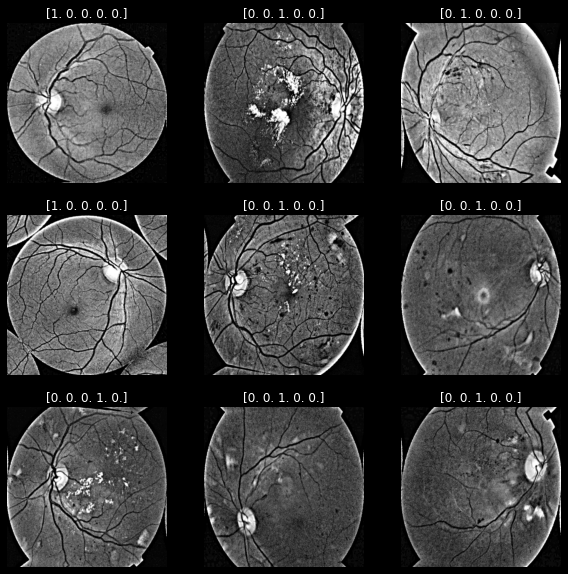

In [23]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(train_images_7[idx]))
    plt.title(str(train_labels_7[idx]))
    plt.axis("off")

plt.show

# Train classifier

In [24]:
conv_base = inception_v3.InceptionV3(
    include_top=False, weights="imagenet", input_shape=(image_shape))

conv_base.trainable = False
conv_base.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 191, 191, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 191, 191, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 191, 191, 32) 0           batch_normalization[0][0]        
______________________

In [25]:
utils.plot_model(conv_base, show_layer_names=True, show_shapes=True)

In [26]:
input_layer = keras.Input(shape=image_shape)
x = inception_v3.preprocess_input(input_layer)
x = conv_base(x, training=False)
x1 = layers.GlobalAveragePooling2D()(x)
x2 = layers.GlobalMaxPooling2D()(x)
x = layers.Concatenate()([x1, x2])
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, kernel_regularizer="l2", bias_regularizer="l2")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.3)(x)
output_layer = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs=input_layer, outputs=output_layer)

In [27]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics,
)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv (TensorFlow [(None, 384, 384, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Sub (TensorFlowOpLa [(None, 384, 384, 3) 0           tf_op_layer_RealDiv[0][0]        
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 10, 10, 2048) 21802784    tf_op_layer_Sub[0][0]            
_______________________________________________________________________________________

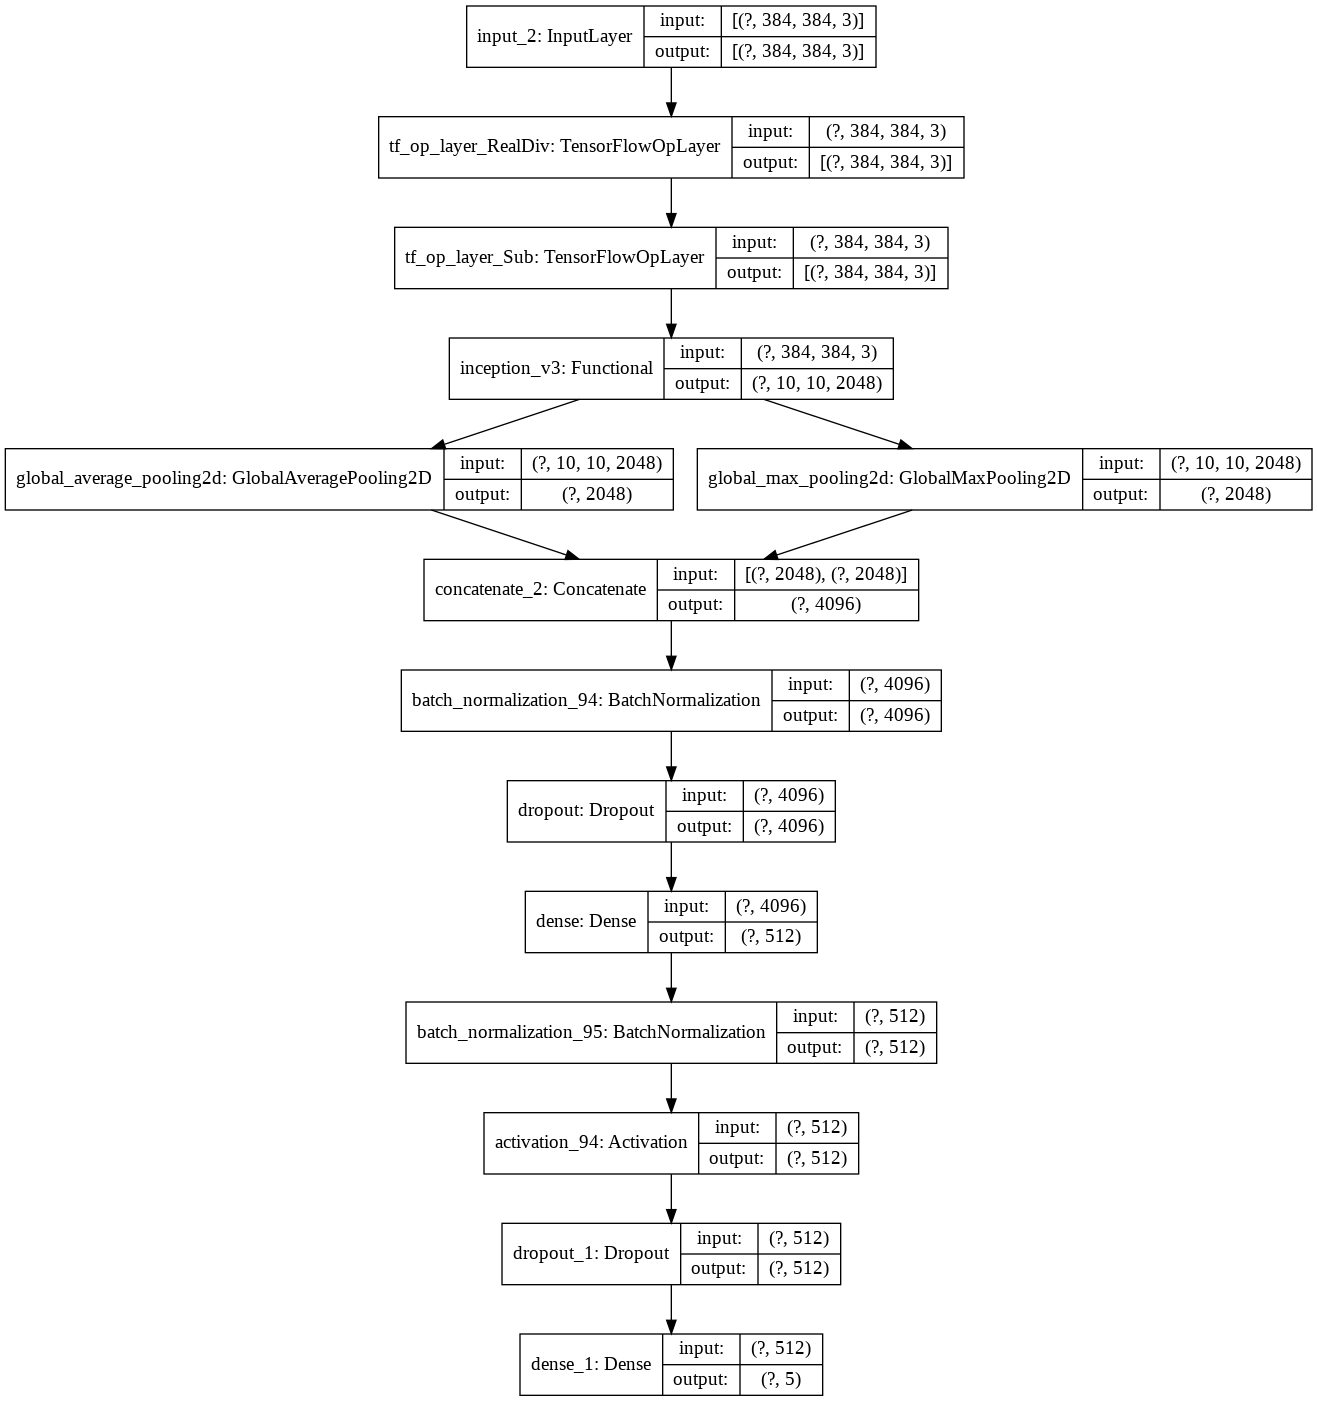

In [28]:
utils.plot_model(model, show_layer_names=True, show_shapes=True)

In [29]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks,
)

Epoch 1/50
184/184 [==============================] - 1252s 7s/step - loss: 10.2643 - categorical_accuracy: 0.5469 - precision: 0.6360 - recall: 0.4302 - auc: 0.8219 - val_loss: 9.4870 - val_categorical_accuracy: 0.6262 - val_precision: 0.7800 - val_recall: 0.3724 - val_auc: 0.8859
Epoch 2/50
184/184 [==============================] - 214s 1s/step - loss: 9.4283 - categorical_accuracy: 0.6135 - precision: 0.6974 - recall: 0.5288 - auc: 0.8765 - val_loss: 8.6372 - val_categorical_accuracy: 0.7108 - val_precision: 0.8155 - val_recall: 0.5730 - val_auc: 0.9326
Epoch 3/50
184/184 [==============================] - 207s 1s/step - loss: 8.7435 - categorical_accuracy: 0.6483 - precision: 0.7230 - recall: 0.5685 - auc: 0.8993 - val_loss: 8.0898 - val_categorical_accuracy: 0.6862 - val_precision: 0.7513 - val_recall: 0.5935 - val_auc: 0.9277
Epoch 4/50
184/184 [==============================] - 201s 1s/step - loss: 8.1392 - categorical_accuracy: 0.6576 - precision: 0.7312 - recall: 0.5825 - auc

In [30]:
model.save(os.path.join(save_dir,"inception-rescale-classifier.h5"))

## Plot training result

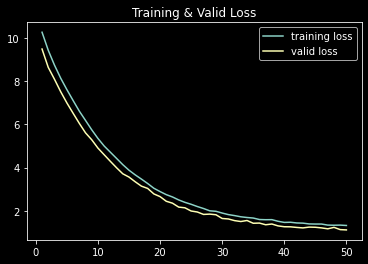

In [31]:
plot_loss(history)

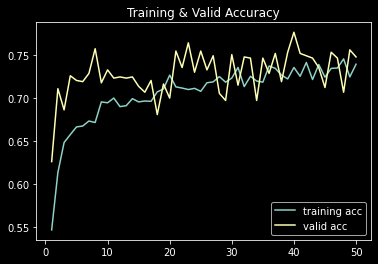

In [32]:
plot_acc(history)

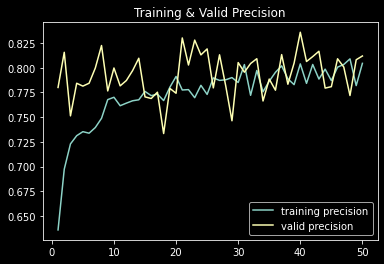

In [33]:
plot_precision(history)

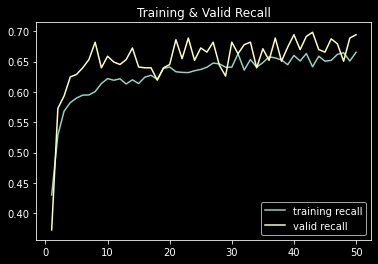

In [34]:
plot_recall(history)

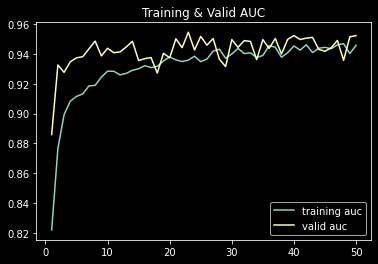

In [35]:
plot_auc(history)

## Evaluate model

In [36]:
model.metrics_names

['loss', 'categorical_accuracy', 'precision', 'recall', 'auc']

In [37]:
model.evaluate(valid_generator, verbose=1)

46/46 [==============================] - 21s 453ms/step - loss: 1.1151 - categorical_accuracy: 0.7476 - precision: 0.8118 - recall: 0.6944 - auc: 0.9523


[1.1150888204574585,
 0.7476125359535217,
 0.8118022084236145,
 0.6944065690040588,
 0.9522915482521057]

In [ ]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [ ]:
y_true[:10]

In [ ]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

In [ ]:
y_pred[:10]

In [42]:
print(classification_report(y_true, y_pred, target_names=["normal", "mild", "moderate","severe","proliferative"]))

               precision    recall  f1-score   support

       normal       0.97      0.96      0.97       361
         mild       0.51      0.65      0.57        74
     moderate       0.77      0.48      0.60       200
       severe       0.34      0.54      0.42        39
proliferative       0.38      0.61      0.46        59

     accuracy                           0.75       733
    macro avg       0.59      0.65      0.60       733
 weighted avg       0.79      0.75      0.76       733



In [ ]:
confusion_matrix(y_true, y_pred)

# Fine Tune

In [ ]:
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

In [ ]:
# fine tune 2 blocks of Inception, block 9 & 10
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == "mixed8":
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

In [ ]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=2e-6),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics,
)

model.summary()

In [48]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks,
)

Epoch 1/100
184/184 [==============================] - 203s 1s/step - loss: 1.2896 - categorical_accuracy: 0.7488 - precision: 0.8063 - recall: 0.6786 - auc: 0.9503 - val_loss: 1.1098 - val_categorical_accuracy: 0.7572 - val_precision: 0.8156 - val_recall: 0.6999 - val_auc: 0.9529
Epoch 2/100
184/184 [==============================] - 200s 1s/step - loss: 1.2692 - categorical_accuracy: 0.7504 - precision: 0.8090 - recall: 0.6767 - auc: 0.9485 - val_loss: 1.0960 - val_categorical_accuracy: 0.7626 - val_precision: 0.8160 - val_recall: 0.7080 - val_auc: 0.9549
Epoch 3/100
184/184 [==============================] - 202s 1s/step - loss: 1.2356 - categorical_accuracy: 0.7573 - precision: 0.8230 - recall: 0.6825 - auc: 0.9524 - val_loss: 1.1044 - val_categorical_accuracy: 0.7558 - val_precision: 0.8175 - val_recall: 0.7026 - val_auc: 0.9535
Epoch 4/100
184/184 [==============================] - 201s 1s/step - loss: 1.2310 - categorical_accuracy: 0.7658 - precision: 0.8262 - recall: 0.7030 - a

In [49]:
model.save(os.path.join(save_dir,"inception-rescale-finetune.h5"))

## Plot training result

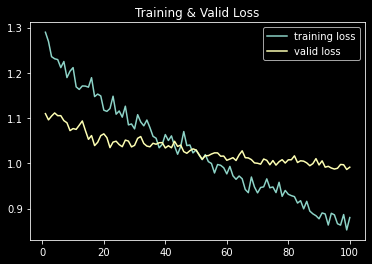

In [50]:
plot_loss(history)

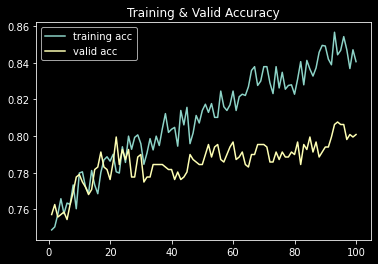

In [51]:
plot_acc(history)

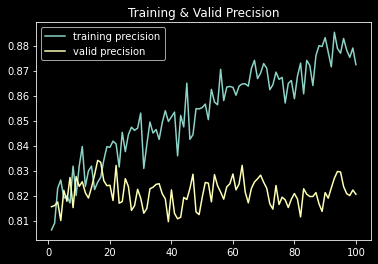

In [52]:
plot_precision(history)

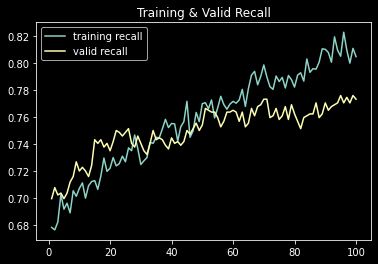

In [53]:
plot_recall(history)

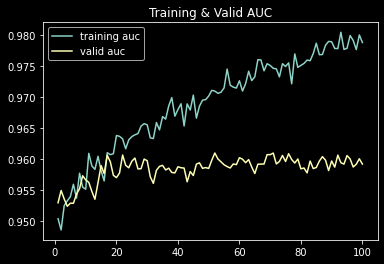

In [54]:
plot_auc(history)

## Evaluate model

In [55]:
model.metrics_names

['loss', 'categorical_accuracy', 'precision', 'recall', 'auc']

In [56]:
model.evaluate(valid_generator, verbose=1)

46/46 [==============================] - 20s 441ms/step - loss: 0.9915 - categorical_accuracy: 0.8008 - precision: 0.8205 - recall: 0.7735 - auc: 0.9591


[0.9914946556091309,
 0.8008185625076294,
 0.8205499053001404,
 0.7735334038734436,
 0.9591460227966309]

In [65]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [66]:
y_true[:10]

[0, 0, 0, 2, 0, 2, 3, 2, 4, 2]

In [67]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

46/46 [==============================] - 21s 454ms/step


In [68]:
y_pred[:10]

[0, 0, 0, 2, 0, 1, 3, 2, 4, 1]

In [69]:
print(classification_report(y_true, y_pred, target_names=["normal", "mild", "moderate","severe","proliferative"]))

               precision    recall  f1-score   support

       normal       0.99      0.96      0.97       361
         mild       0.59      0.72      0.65        74
     moderate       0.80      0.62      0.70       200
       severe       0.37      0.64      0.47        39
proliferative       0.55      0.61      0.58        59

     accuracy                           0.80       733
    macro avg       0.66      0.71      0.67       733
 weighted avg       0.83      0.80      0.81       733



In [70]:
confusion_matrix(y_true, y_pred)

array([[348,  10,   2,   0,   1],
       [  5,  53,  13,   1,   2],
       [  0,  24, 125,  33,  18],
       [  0,   0,   5,  25,   9],
       [  0,   3,  12,   8,  36]])